# 筹码分布应用示例

本Notebook演示如何使用筹码分布进行交易分析，包括不同历史衰减系数的影响、三角形分布与均匀分布的对比、日线与15分钟线的对比，以及支撑阻力位的识别等。

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqsdk import TqApi, TqAuth
import time
import sys
import os

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC', 'Arial Unicode MS']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 添加当前目录到系统路径
sys.path.append('.')

# 导入自定义的筹码分布计算类
from analysis_tools.chip_distribution import ChipDistribution

在使用天勤量化之前，默认您已经知晓并同意以下免责条款，如果不同意请立即停止使用：https://www.shinnytech.com/blog/disclaimer/


## 1. 获取数据

我们使用TqSdk获取郑商所FG601合约的日线和15分钟K线数据。

In [2]:
# 连接TqApi
try:
    api = TqApi(auth=TqAuth('guowei121493', 'gw052427'))
    # 获取FG601合约的日线数据
    klines_day = api.get_kline_serial('CZCE.FG601', duration_seconds=24*60*60, data_length=200)
    # 获取FG601合约的15分钟线数据
    klines_15min = api.get_kline_serial('CZCE.FG601', duration_seconds=15*60, data_length=500)
    # 等待数据就绪
    api.wait_update()
    
    # 将日线数据转换为DataFrame格式
    df_day = pd.DataFrame({
        'datetime': klines_day['datetime'],
        'open': klines_day['open'],
        'high': klines_day['high'],
        'low': klines_day['low'],
        'close': klines_day['close'],
        'volume': klines_day['volume'],
        'open_interest': klines_day['close_oi']
    })
    
    # 将15分钟线数据转换为DataFrame格式
    df_15min = pd.DataFrame({
        'datetime': klines_15min['datetime'],
        'open': klines_15min['open'],
        'high': klines_15min['high'],
        'low': klines_15min['low'],
        'close': klines_15min['close'],
        'volume': klines_15min['volume'],
        'open_interest': klines_15min['close_oi']
    })
    
    # 将datetime转换为日期格式并设置为索引
    df_day['date'] = pd.to_datetime(df_day['datetime'], unit='ns')
    df_day.set_index('date', inplace=True)
    df_day.drop('datetime', axis=1, inplace=True)
    
    df_15min['datetime'] = pd.to_datetime(df_15min['datetime'], unit='ns')
    df_15min.set_index('datetime', inplace=True)
    
    print(f'获取到FG601合约的日线数据，共{len(df_day)}条记录')
    print(f'获取到FG601合约的15分钟线数据，共{len(df_15min)}条记录')
    print('日线数据日期范围：', df_day.index.min(), '至', df_day.index.max())
    print('15分钟线数据日期范围：', df_15min.index.min(), '至', df_15min.index.max())
    
finally:
    # 关闭连接
    api.close()

2025-09-04 22:14:42 -     INFO - TqSdk trial 版剩余 14 天到期，如需续费或升级请访问 https://account.shinnytech.com/ 或联系相关工作人员。
2025-09-04 22:14:43 -     INFO - 通知 : 与 wss://api.shinnytech.com/t/nfmd/front/mobile 的网络连接已建立
获取到FG601合约的日线数据，共200条记录
获取到FG601合约的15分钟线数据，共500条记录
日线数据日期范围： 1970-01-01 00:00:00 至 2025-09-04 16:00:00
15分钟线数据日期范围： 2025-08-06 01:45:00 至 2025-09-04 14:00:00


## 2. 不同历史衰减系数对筹码分布的影响

历史衰减系数决定了旧数据对当前筹码分布的影响程度。较高的衰减系数表示更重视近期数据，而较低的衰减系数则表示更重视历史数据。

/Users/weiguo/quant/tqsdk/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


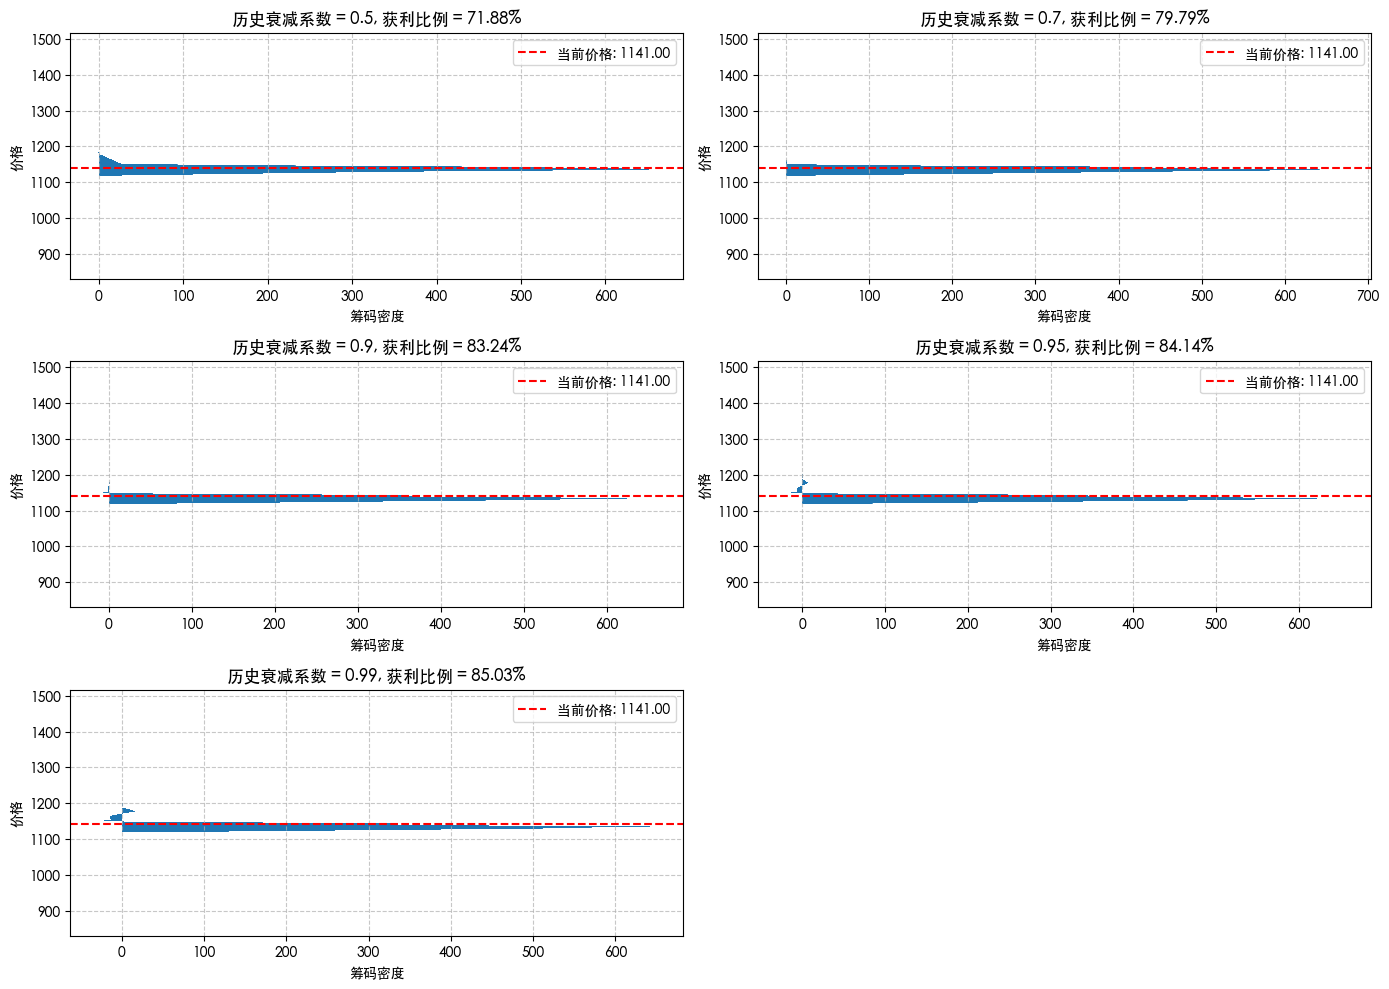

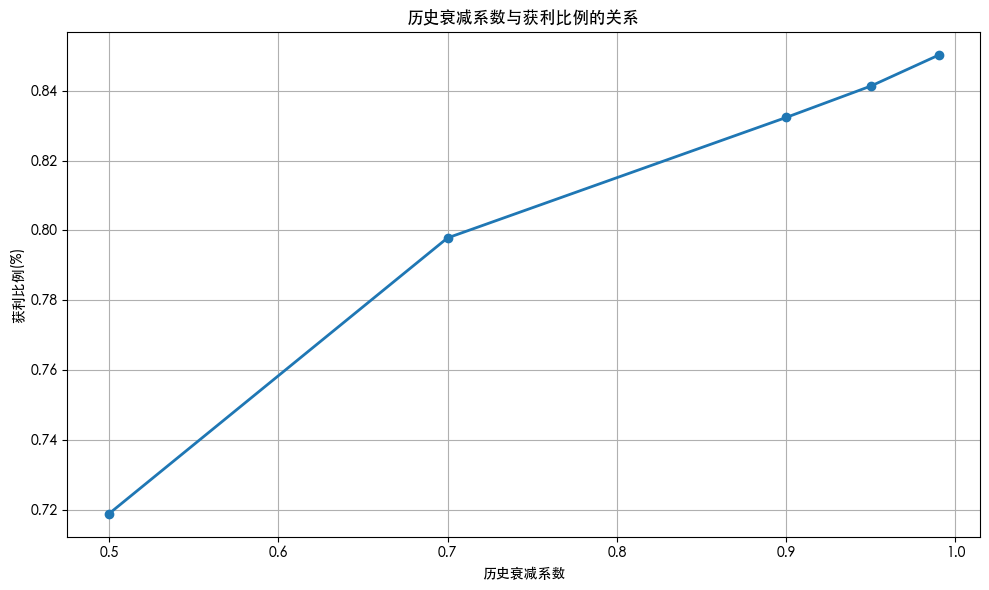

历史衰减系数影响分析:
1. 较高的衰减系数(如0.99)表示近期交易对筹码分布影响更大
2. 较低的衰减系数(如0.5)表示历史交易对筹码分布影响更持久
3. 当市场价格快速上涨时，高衰减系数会显示更高的获利比例
4. 选择合适的衰减系数应考虑品种的流动性和价格波动特性


In [3]:
# 定义不同的历史衰减系数
decay_coefficients = [0.5, 0.7, 0.9, 0.95, 0.99]
# 假设总流通盘为100万手
total_shares = 1000000

# 创建图表来展示不同衰减系数的效果
plt.figure(figsize=(14, 10))

# 获取当前价格
current_price = df_day.iloc[-1]['close']

# 存储不同衰减系数下的获利比例
profit_ratios = []

# 遍历不同的衰减系数
for i, decay in enumerate(decay_coefficients):
    # 创建筹码分布实例
    chip_dist = ChipDistribution(decay_coefficient=decay)
    
    # 计算筹码分布
    for idx, row in df_day.iterrows():
        turnover_rate = row['volume'] / total_shares * 100  # 转换为百分比
        avg = (row['high'] + row['low'] + row['close']) / 3  # 计算平均价
        chip_dist.calculate_triangle_distribution(idx, row['high'], row['low'], avg, row['volume'], turnover_rate)
    
    # 获取筹码分布数据
    if chip_dist.price_vol:
        price_bins = sorted(chip_dist.price_vol.keys())
        chip_density = [chip_dist.price_vol[price] for price in price_bins]
    else:
        price_bins, chip_density = [], [] 
    
    # 计算获利比例
    profit_ratio = chip_dist.get_profit_ratio(current_price)
    profit_ratios.append(profit_ratio)
    
    # 绘制筹码分布
    plt.subplot(3, 2, i+1)
    plt.barh(price_bins, chip_density, height=0.1, alpha=0.7)
    plt.axhline(y=current_price, color='r', linestyle='--', label=f'当前价格: {current_price:.2f}')
    plt.title(f'历史衰减系数 = {decay}, 获利比例 = {profit_ratio:.2%}')
    plt.xlabel('筹码密度')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 绘制衰减系数与获利比例的关系
plt.figure(figsize=(10, 6))
plt.plot(decay_coefficients, profit_ratios, 'o-', linewidth=2)
plt.title('历史衰减系数与获利比例的关系')
plt.xlabel('历史衰减系数')
plt.ylabel('获利比例(%)')
plt.grid(True)
plt.tight_layout()
plt.show()

print('历史衰减系数影响分析:')
print('1. 较高的衰减系数(如0.99)表示近期交易对筹码分布影响更大')
print('2. 较低的衰减系数(如0.5)表示历史交易对筹码分布影响更持久')
print('3. 当市场价格快速上涨时，高衰减系数会显示更高的获利比例')
print('4. 选择合适的衰减系数应考虑品种的流动性和价格波动特性')

## 3. 三角形分布与均匀分布算法对比

筹码分布计算中常用两种算法：三角形分布和均匀分布。本部分将对比这两种算法的差异。

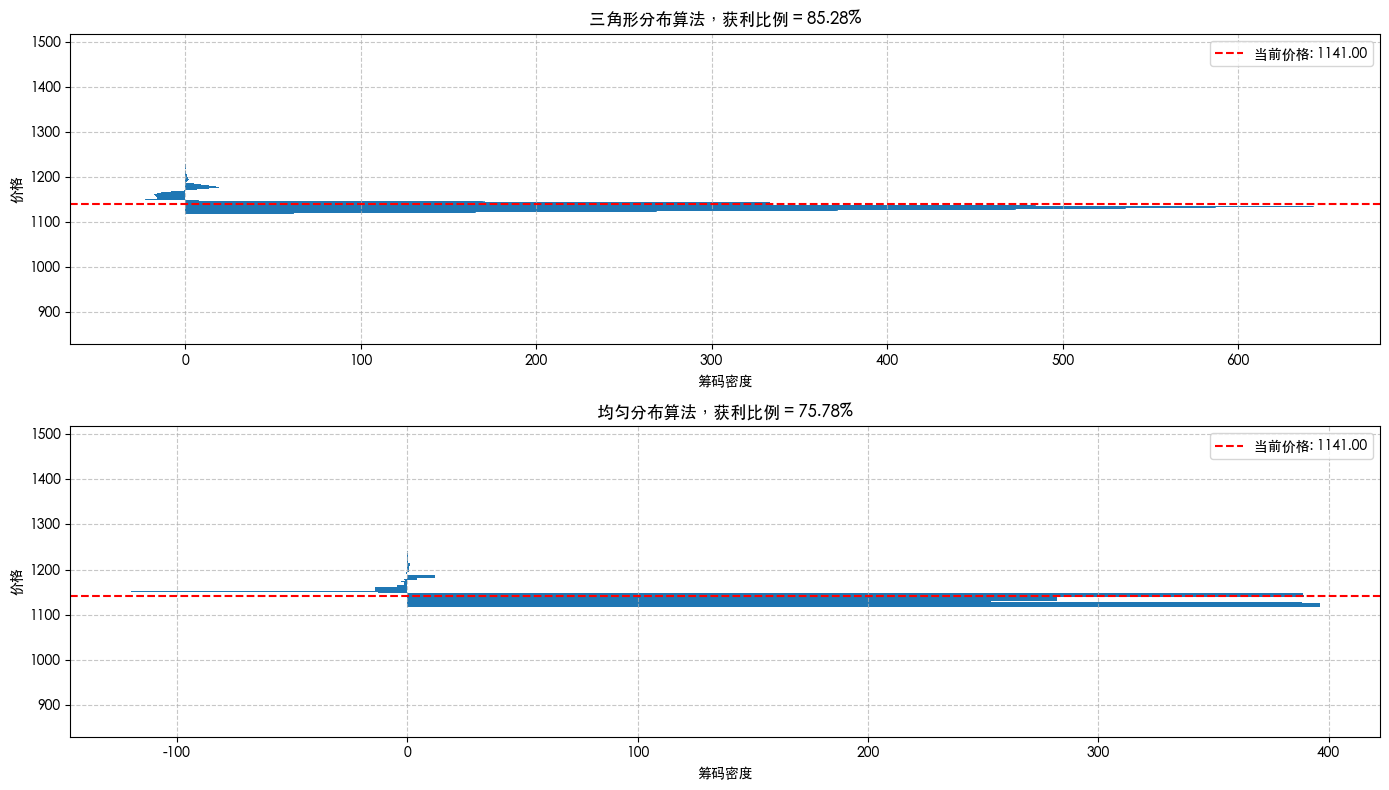

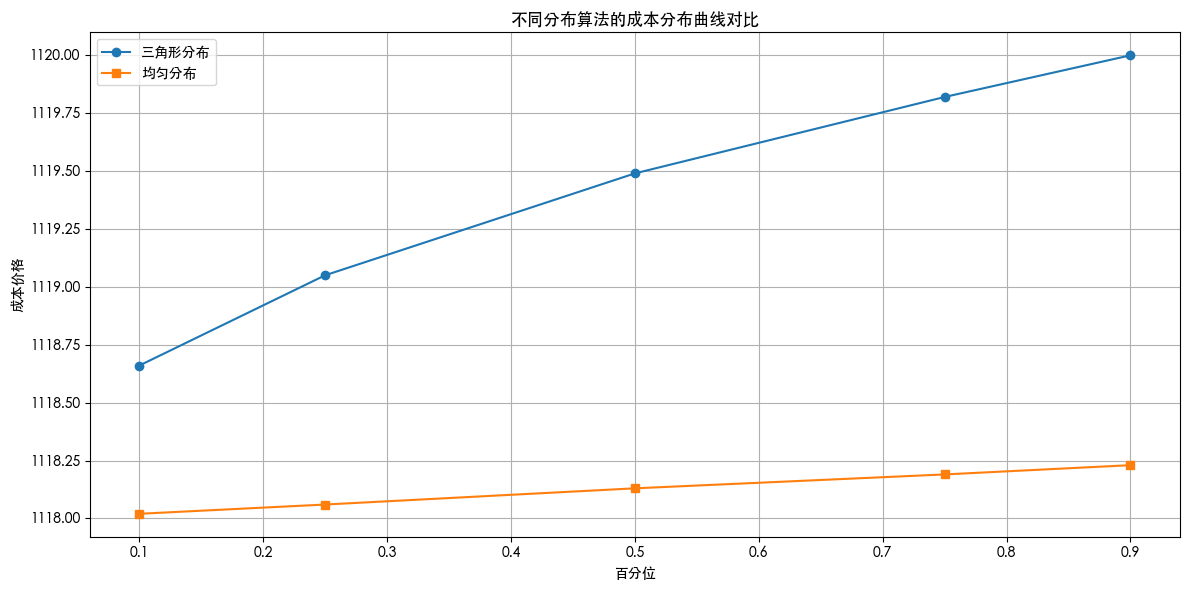

分布算法对比分析:
1. 三角形分布更重视收盘价附近的交易，认为这些价格水平的筹码更集中
2. 均匀分布假设价格区间内的交易是均匀分布的，不特别强调某一价格点
3. 在实际应用中，三角形分布通常更符合市场实际情况，特别是在趋势市场中
4. 均匀分布计算更简单，但可能在某些情况下不够准确地反映筹码集中度


In [4]:
# 创建两种不同算法的筹码分布实例
chip_dist_triangle = ChipDistribution(decay_coefficient=1) 
chip_dist_uniform = ChipDistribution(decay_coefficient=1) 

# 计算筹码分布（使用日线数据）
for idx, row in df_day.iterrows(): 
    turnover_rate = row['volume'] / total_shares * 100  # 转换为百分比
    avg = (row['high'] + row['low'] + row['close']) / 3  # 计算平均价
    chip_dist_triangle.calculate_triangle_distribution(idx, row['high'], row['low'], avg, row['volume'], turnover_rate) 
    chip_dist_uniform.calculate_even_distribution(idx, row['high'], row['low'], row['volume'], turnover_rate) 

# 获取筹码分布数据
if chip_dist_triangle.price_vol: 
    price_bins_triangle = sorted(chip_dist_triangle.price_vol.keys()) 
    chip_density_triangle = [chip_dist_triangle.price_vol[price] for price in price_bins_triangle] 
else: 
    price_bins_triangle, chip_density_triangle = [], [] 

if chip_dist_uniform.price_vol: 
    price_bins_uniform = sorted(chip_dist_uniform.price_vol.keys()) 
    chip_density_uniform = [chip_dist_uniform.price_vol[price] for price in price_bins_uniform] 
else: 
    price_bins_uniform, chip_density_uniform = [], [] 

# 计算获利比例
profit_ratio_triangle = chip_dist_triangle.get_profit_ratio(current_price) 
profit_ratio_uniform = chip_dist_uniform.get_profit_ratio(current_price) 

# 可视化对比
plt.figure(figsize=(14, 8)) 

# 三角形分布
plt.subplot(2, 1, 1) 
plt.barh(price_bins_triangle, chip_density_triangle, height=0.1, alpha=0.7) 
plt.axhline(y=current_price, color='r', linestyle='--', label=f'当前价格: {current_price:.2f}') 
plt.title(f'三角形分布算法，获利比例 = {profit_ratio_triangle:.2%}') 
plt.xlabel('筹码密度') 
plt.ylabel('价格') 
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.7) 

# 均匀分布
plt.subplot(2, 1, 2) 
plt.barh(price_bins_uniform, chip_density_uniform, height=0.1, alpha=0.7) 
plt.axhline(y=current_price, color='r', linestyle='--', label=f'当前价格: {current_price:.2f}') 
plt.title(f'均匀分布算法，获利比例 = {profit_ratio_uniform:.2%}') 
plt.xlabel('筹码密度') 
plt.ylabel('价格') 
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.7) 

plt.tight_layout() 
plt.show() 

# 计算成本分布对比
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
cost_triangle = []
cost_uniform = []

for p in percentiles:
    cost_t = chip_dist_triangle.get_cost_distribution(p)
    cost_u = chip_dist_uniform.get_cost_distribution(p)
    cost_triangle.append(cost_t)
    cost_uniform.append(cost_u)

# 绘制成本分布曲线对比
plt.figure(figsize=(12, 6))
plt.plot(percentiles, cost_triangle, 'o-', label='三角形分布')
plt.plot(percentiles, cost_uniform, 's-', label='均匀分布')
plt.title('不同分布算法的成本分布曲线对比')
plt.xlabel('百分位')
plt.ylabel('成本价格')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print('分布算法对比分析:')
print('1. 三角形分布更重视收盘价附近的交易，认为这些价格水平的筹码更集中')
print('2. 均匀分布假设价格区间内的交易是均匀分布的，不特别强调某一价格点')
print('3. 在实际应用中，三角形分布通常更符合市场实际情况，特别是在趋势市场中')
print('4. 均匀分布计算更简单，但可能在某些情况下不够准确地反映筹码集中度')

## 4. 日线与15分钟线周期对比

不同时间周期的筹码分布可以提供不同的市场视角。本部分将对比日线和15分钟线的筹码分布差异。

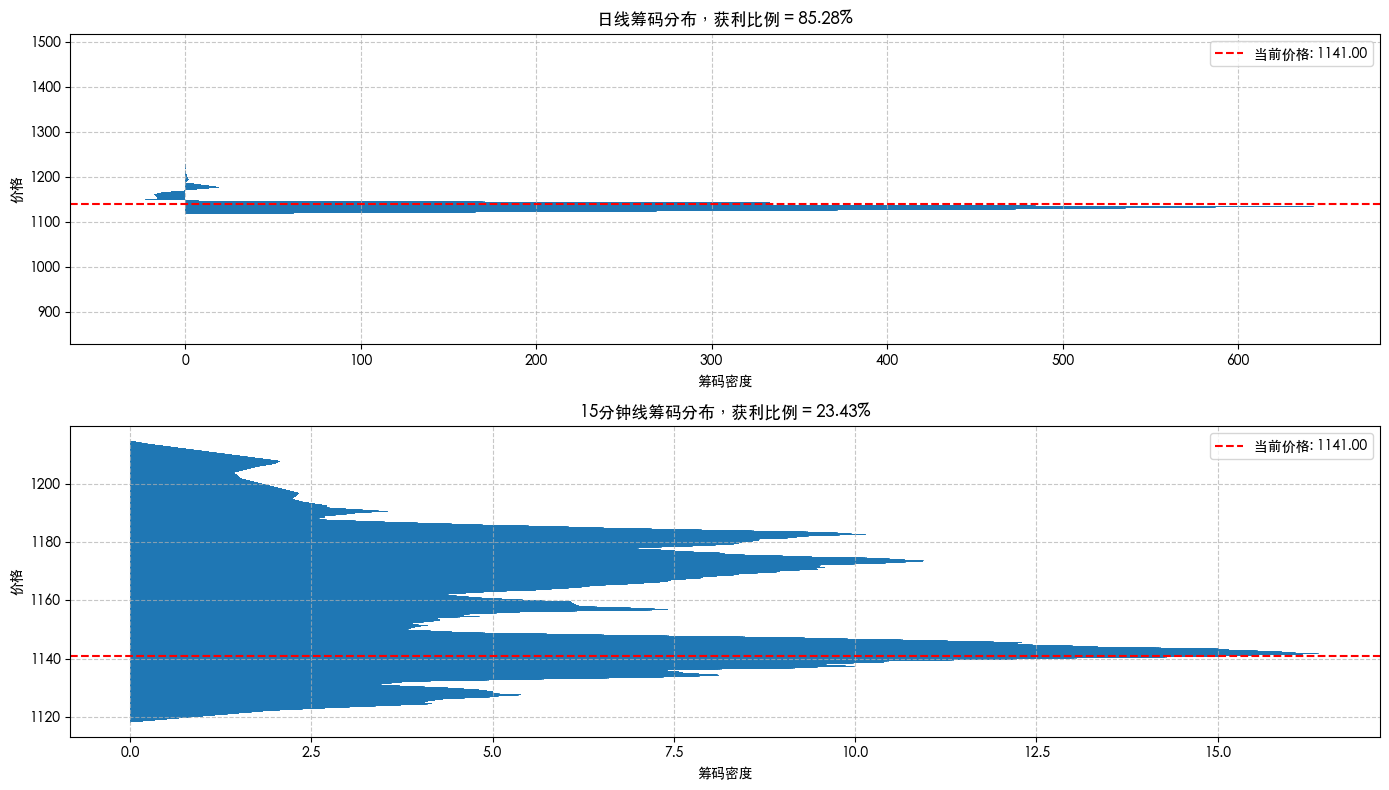

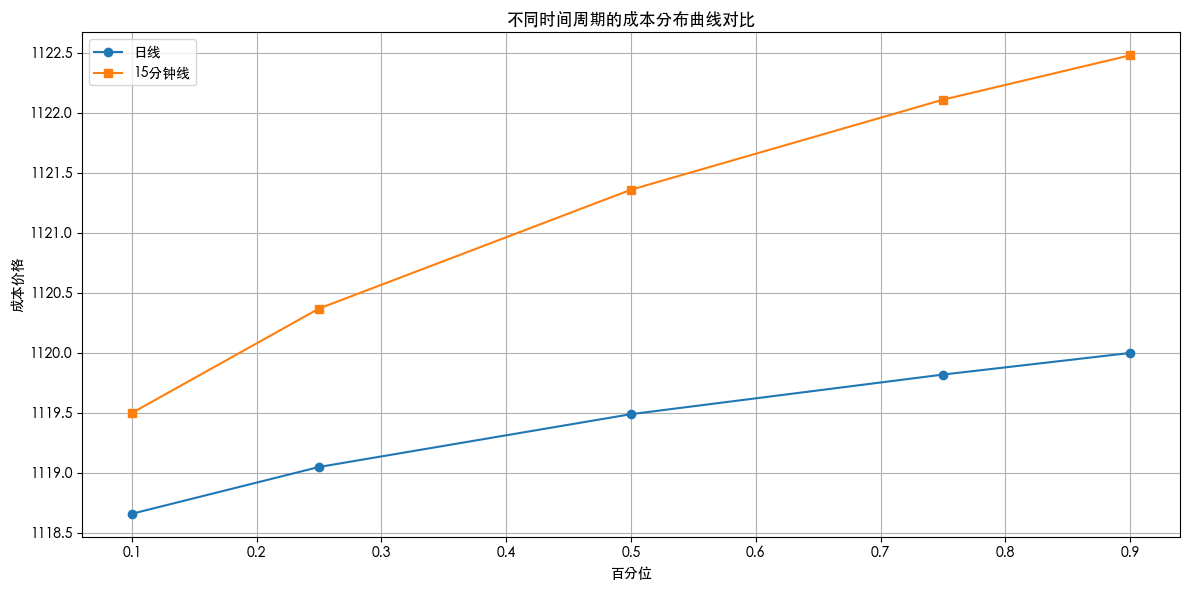

时间周期对比分析:
1. 日线筹码分布反映了较长期的市场持仓成本结构
2. 15分钟线筹码分布反映了短期的市场资金流向和筹码变化
3. 结合不同周期的筹码分布分析，可以更全面地了解市场多空力量对比
4. 日线筹码分布中的重要成本位往往构成重要的支撑或阻力
5. 15分钟线筹码分布可以帮助识别短期的交易机会


In [5]:
# 创建两个不同周期的筹码分布实例
chip_dist_day = ChipDistribution(decay_coefficient=1) 
chip_dist_15min = ChipDistribution(decay_coefficient=1) 

# 使用日线数据计算筹码分布
for idx, row in df_day.iterrows(): 
    turnover_rate = row['volume'] / total_shares * 100  # 转换为百分比
    avg = (row['high'] + row['low'] + row['close']) / 3  # 计算平均价
    chip_dist_day.calculate_triangle_distribution(idx, row['high'], row['low'], avg, row['volume'], turnover_rate) 

# 使用15分钟线数据计算筹码分布
# 由于15分钟线数据较多，我们只使用最近的200条记录
recent_15min_data = df_15min.tail(200)
for idx, row in recent_15min_data.iterrows(): 
    # 注意：15分钟线的换手率需要调整，因为总流通盘是基于日度的
    # 这里简化处理，假设日度总成交量是15分钟成交量的集合
    adjusted_turnover_rate = row['volume'] / (total_shares * 16) * 100  # 假设每天有16个15分钟周期，转换为百分比
    avg = (row['high'] + row['low'] + row['close']) / 3  # 计算平均价
    chip_dist_15min.calculate_triangle_distribution(idx, row['high'], row['low'], avg, row['volume'], adjusted_turnover_rate) 

# 获取当前价格（使用日线收盘价）
current_price_day = df_day.iloc[-1]['close']
current_price_15min = df_15min.iloc[-1]['close']

# 计算获利比例
profit_ratio_day = chip_dist_day.get_profit_ratio(current_price_day)
profit_ratio_15min = chip_dist_15min.get_profit_ratio(current_price_15min)

# 获取筹码分布数据
price_bins_day, chip_density_day = chip_dist_day.get_chip_distribution()
price_bins_15min, chip_density_15min = chip_dist_15min.get_chip_distribution()

# 可视化对比
plt.figure(figsize=(14, 8))

# 日线筹码分布
plt.subplot(2, 1, 1)
plt.barh(price_bins_day, chip_density_day, height=0.1, alpha=0.7)
plt.axhline(y=current_price_day, color='r', linestyle='--', label=f'当前价格: {current_price_day:.2f}')
plt.title(f'日线筹码分布，获利比例 = {profit_ratio_day:.2%}')
plt.xlabel('筹码密度')
plt.ylabel('价格')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 15分钟线筹码分布
plt.subplot(2, 1, 2)
plt.barh(price_bins_15min, chip_density_15min, height=0.1, alpha=0.7)
plt.axhline(y=current_price_15min, color='r', linestyle='--', label=f'当前价格: {current_price_15min:.2f}')
plt.title(f'15分钟线筹码分布，获利比例 = {profit_ratio_15min:.2%}')
plt.xlabel('筹码密度')
plt.ylabel('价格')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 计算不同周期的成本分布对比
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
cost_day = []
cost_15min = []

for p in percentiles:
    cost_d = chip_dist_day.get_cost_distribution(p)
    cost_m = chip_dist_15min.get_cost_distribution(p)
    cost_day.append(cost_d)
    cost_15min.append(cost_m)

# 绘制成本分布曲线对比
plt.figure(figsize=(12, 6))
plt.plot(percentiles, cost_day, 'o-', label='日线')
plt.plot(percentiles, cost_15min, 's-', label='15分钟线')
plt.title('不同时间周期的成本分布曲线对比')
plt.xlabel('百分位')
plt.ylabel('成本价格')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print('时间周期对比分析:')
print('1. 日线筹码分布反映了较长期的市场持仓成本结构')
print('2. 15分钟线筹码分布反映了短期的市场资金流向和筹码变化')
print('3. 结合不同周期的筹码分布分析，可以更全面地了解市场多空力量对比')
print('4. 日线筹码分布中的重要成本位往往构成重要的支撑或阻力')
print('5. 15分钟线筹码分布可以帮助识别短期的交易机会')

## 5. 支撑阻力位识别及交易决策应用

筹码分布可以帮助识别市场中的重要支撑和阻力位。本部分将介绍如何利用筹码分布进行交易决策。

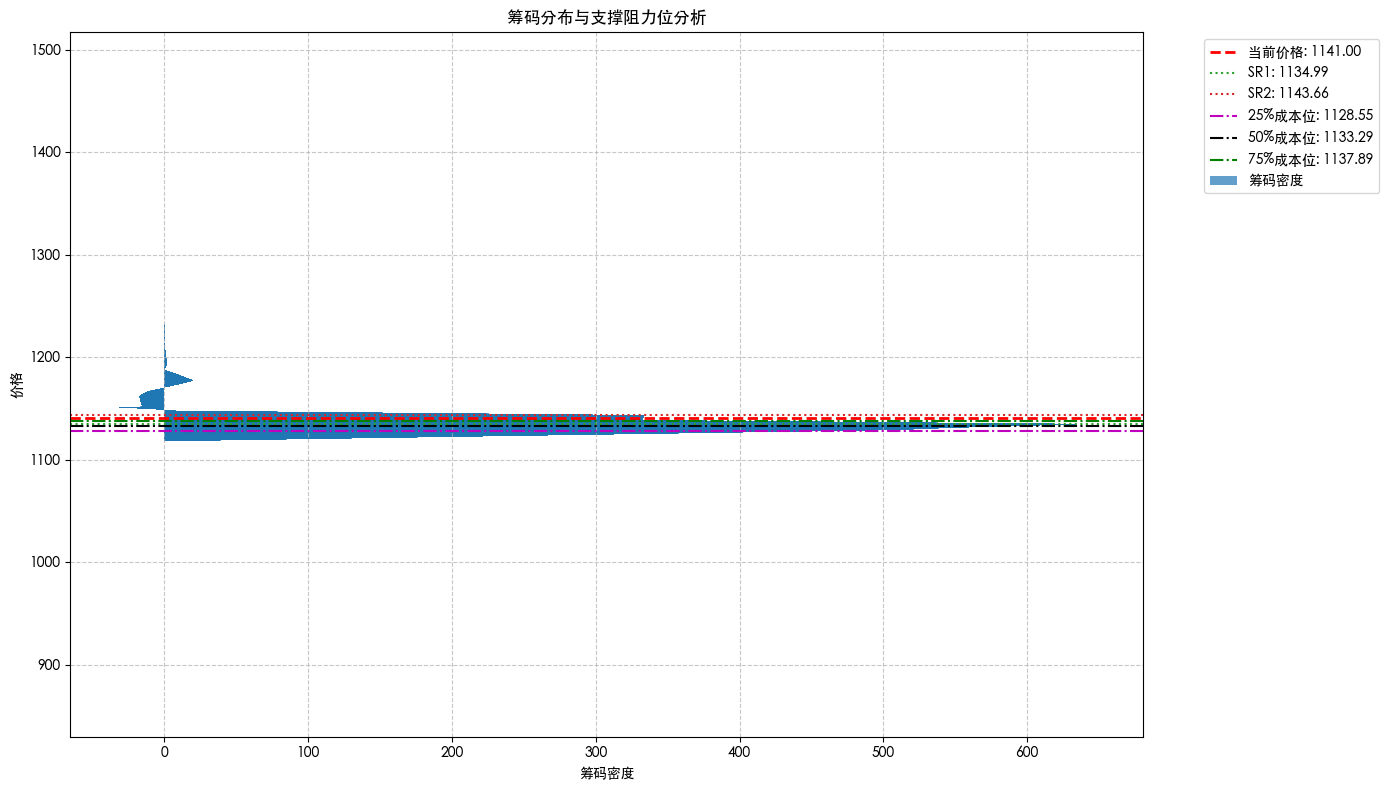

===== 交易决策分析 =====
当前价格: 1141.00
当前获利比例: 85.28%
主要支撑阻力位:
  阻力位1: 1134.99 (上方0.53%)
  支撑位2: 1143.66 (下方0.23%)
关键成本位:
  25%成本位: 1128.55
  50%成本位(平均成本): 1133.29
  75%成本位: 1137.89
交易策略建议:
1. 当前市场获利比例较高(>70%)，上方压力较大，建议谨慎追高
   当前价格已突破最强阻力位1134.99，若能站稳则可能打开上行空间
2. 价格接近平均成本，多空力量相对平衡
3. 支撑阻力位交易策略:
   - 在支撑位附近可考虑低吸，设置止损在支撑位下方
   - 在阻力位附近可考虑高抛，设置止盈在阻力位上方
   - 关注价格对关键支撑阻力位的突破情况，突破后的回踩确认是较好的入场点
   - 结合成交量变化判断突破的有效性
4. 风险控制建议:
   - 无论采取何种策略，都应设置合理的止损位
   - 不要将所有资金集中在单一交易上，合理分散风险
   - 筹码分布分析应结合其他技术指标和基本面分析综合判断


In [6]:
# 使用日线数据创建筹码分布实例
chip_dist = ChipDistribution(decay_coefficient=1) 

# 计算筹码分布
for idx, row in df_day.iterrows(): 
    turnover_rate = row['volume'] / total_shares * 100  # 转换为百分比
    avg = (row['high'] + row['low'] + row['close']) / 3  # 计算平均价
    chip_dist.calculate_triangle_distribution(idx, row['high'], row['low'], avg, row['volume'], turnover_rate) 

# 获取筹码分布数据并计算支撑阻力位
if chip_dist.price_vol: 
    price_bins = sorted(chip_dist.price_vol.keys()) 
    chip_density = [chip_dist.price_vol[price] for price in price_bins] 
else: 
    price_bins, chip_density = [], [] 

# 将价格和筹码密度转换为numpy数组便于计算
price_array = np.array(price_bins) 
density_array = np.array(chip_density) 

# 计算筹码峰值（支撑阻力位）
# 寻找密度最大的几个峰值
from scipy.signal import find_peaks 

# 使用find_peaks函数寻找峰值
# height参数设置峰值的最小高度，prominence参数设置峰值的最小突出度
peaks, properties = find_peaks(density_array, height=np.max(density_array)*0.3, prominence=0.1) 

# 获取峰值对应的价格水平（支撑阻力位）
support_resistance_levels = price_array[peaks] 
peak_densities = density_array[peaks] 

# 按密度从大到小排序
sorted_indices = np.argsort(peak_densities)[::-1] 
support_resistance_levels = support_resistance_levels[sorted_indices] 
peak_densities = peak_densities[sorted_indices] 

# 计算关键成本位（25%、50%、75%百分位）
cost_25 = chip_dist.get_cost_distribution(25) 
cost_50 = chip_dist.get_cost_distribution(50) 
cost_75 = chip_dist.get_cost_distribution(75) 

# 获取当前价格
current_price = df_day.iloc[-1]['close']

# 可视化支撑阻力位和筹码分布
plt.figure(figsize=(14, 8))

# 绘制筹码分布
plt.barh(price_bins, chip_density, height=0.1, alpha=0.7, label='筹码密度')
plt.axhline(y=current_price, color='r', linestyle='--', linewidth=2, label=f'当前价格: {current_price:.2f}')

# 标记支撑阻力位
for i, level in enumerate(support_resistance_levels[:5]):  # 只显示前5个重要的支撑阻力位
    plt.axhline(y=level, color=f'C{i+2}', linestyle=':', linewidth=1.5, label=f'SR{i+1}: {level:.2f}')

# 标记关键成本位
plt.axhline(y=cost_25, color='m', linestyle='-.', linewidth=1.5, label=f'25%成本位: {cost_25:.2f}')
plt.axhline(y=cost_50, color='k', linestyle='-.', linewidth=1.5, label=f'50%成本位: {cost_50:.2f}')
plt.axhline(y=cost_75, color='g', linestyle='-.', linewidth=1.5, label=f'75%成本位: {cost_75:.2f}')

plt.title('筹码分布与支撑阻力位分析')
plt.xlabel('筹码密度')
plt.ylabel('价格')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 结合价格走势和筹码分布进行交易决策分析
# 计算当前价格与各支撑阻力位的距离
print('===== 交易决策分析 =====')
print(f'当前价格: {current_price:.2f}')
print(f'当前获利比例: {chip_dist.get_profit_ratio(current_price):.2%}')
print('主要支撑阻力位:')
for i, level in enumerate(support_resistance_levels[:5]):
    distance = (current_price - level) / level * 100
    if distance > 0:
        print(f'  阻力位{i+1}: {level:.2f} (上方{distance:.2f}%)')
    else:
        print(f'  支撑位{i+1}: {level:.2f} (下方{abs(distance):.2f}%)')

print('关键成本位:')
print(f'  25%成本位: {cost_25:.2f}')
print(f'  50%成本位(平均成本): {cost_50:.2f}')
print(f'  75%成本位: {cost_75:.2f}')

# 基于筹码分布的交易策略建议
print('交易策略建议:')
current_price = df_day.iloc[-1]['close']
profit_ratio = chip_dist.get_profit_ratio(current_price)

# 基于获利比例和支撑阻力位给出建议
if profit_ratio > 0.7:
    print('1. 当前市场获利比例较高(>70%)，上方压力较大，建议谨慎追高')
    if len(support_resistance_levels) > 0 and current_price > support_resistance_levels[0]:
        print(f'   当前价格已突破最强阻力位{support_resistance_levels[0]:.2f}，若能站稳则可能打开上行空间')
elif profit_ratio < 0.3:
    print('1. 当前市场获利比例较低(<30%)，下方支撑较强，可关注逢低买入机会')
    if len(support_resistance_levels) > 0 and current_price < support_resistance_levels[0]:
        print(f'   当前价格处于最强支撑位{support_resistance_levels[0]:.2f}下方，若获得支撑可考虑入场')
else:
    print('1. 当前市场处于平衡状态，获利比例适中')

# 结合平均成本给出建议
if current_price > cost_50 * 1.03:
    print('2. 价格显著高于平均成本，多头占据优势，但需警惕获利回吐')
elif current_price < cost_50 * 0.97:
    print('2. 价格显著低于平均成本，空头占据优势，但空头可能已经过度')
else:
    print('2. 价格接近平均成本，多空力量相对平衡')

# 支撑阻力位的交易建议
print('3. 支撑阻力位交易策略:')
print('   - 在支撑位附近可考虑低吸，设置止损在支撑位下方')
print('   - 在阻力位附近可考虑高抛，设置止盈在阻力位上方')
print('   - 关注价格对关键支撑阻力位的突破情况，突破后的回踩确认是较好的入场点')
print('   - 结合成交量变化判断突破的有效性')

print('4. 风险控制建议:')
print('   - 无论采取何种策略，都应设置合理的止损位')
print('   - 不要将所有资金集中在单一交易上，合理分散风险')
print('   - 筹码分布分析应结合其他技术指标和基本面分析综合判断')

## 6. 总结与展望

本Notebook介绍了筹码分布的多种应用场景和分析方法。通过合理运用筹码分布分析，我们可以更好地理解市场结构，识别支撑阻力位，并辅助交易决策。

In [ ]:
# 总结筹码分布的应用价值
print('===== 筹码分布分析总结 =====')
print('1. 筹码分布的核心价值在于揭示市场持仓成本结构，帮助理解多空力量对比')
print('2. 关键应用场景:')
- 识别重要的支撑阻力位
- 判断市场强弱和趋势方向
- 发现潜在的反转信号
- 辅助制定交易策略和风险控制计划

print('3. 使用注意事项:')
- 不同参数设置(如历史衰减系数、分布算法)会影响分析结果
- 应结合不同时间周期的筹码分布进行综合分析
- 筹码分布不是万能的，应与其他技术指标和基本面分析结合使用
- 市场是动态变化的，筹码分布也在不断更新，需要持续关注

print('4. 未来研究方向:')
- 开发更复杂的筹码分布模型，考虑更多市场因素
- 研究筹码分布与其他技术指标的协同效应
- 基于筹码分布开发量化交易策略
- 探索机器学习在筹码分布分析中的应用